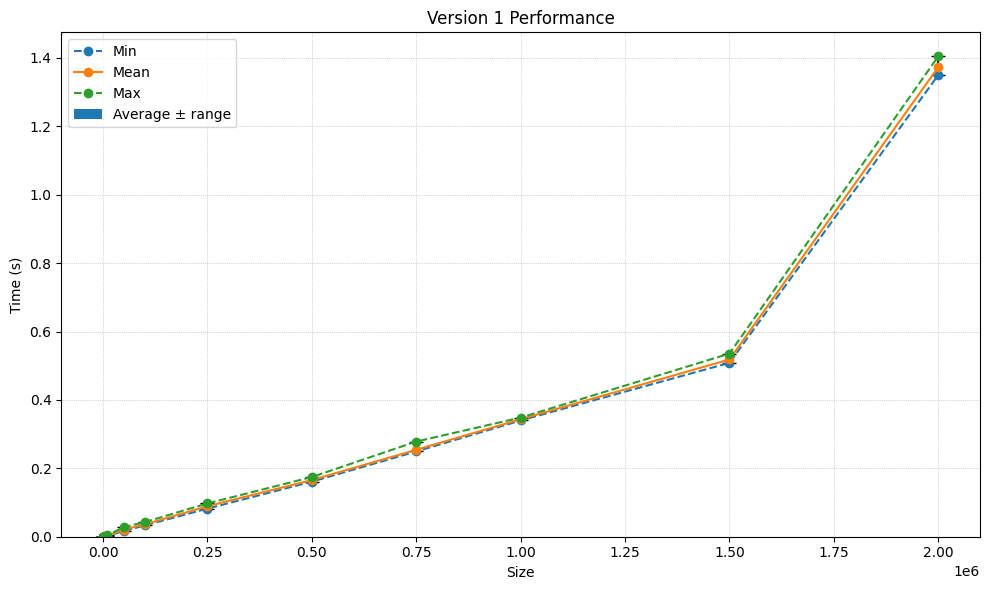

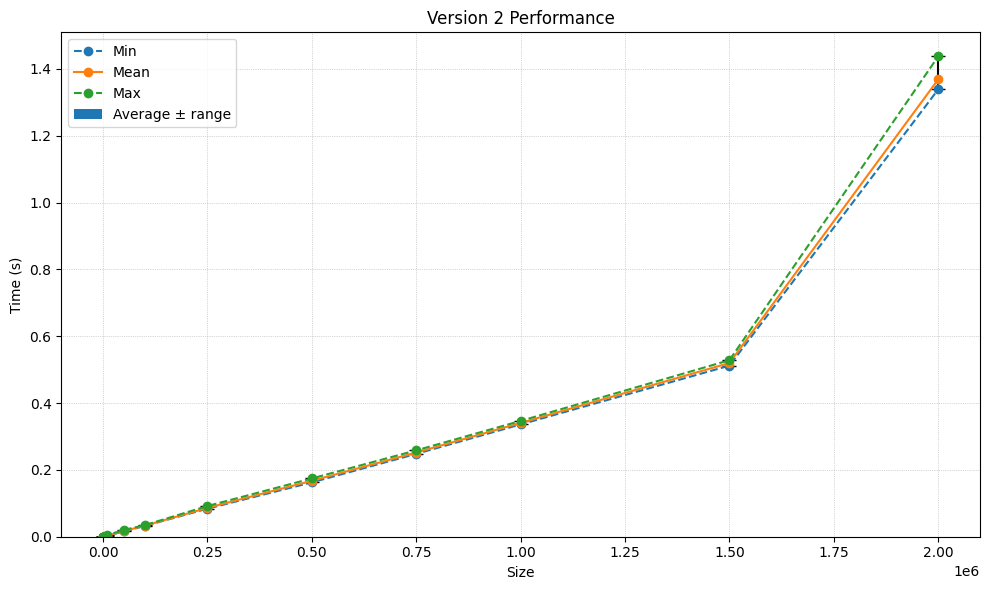

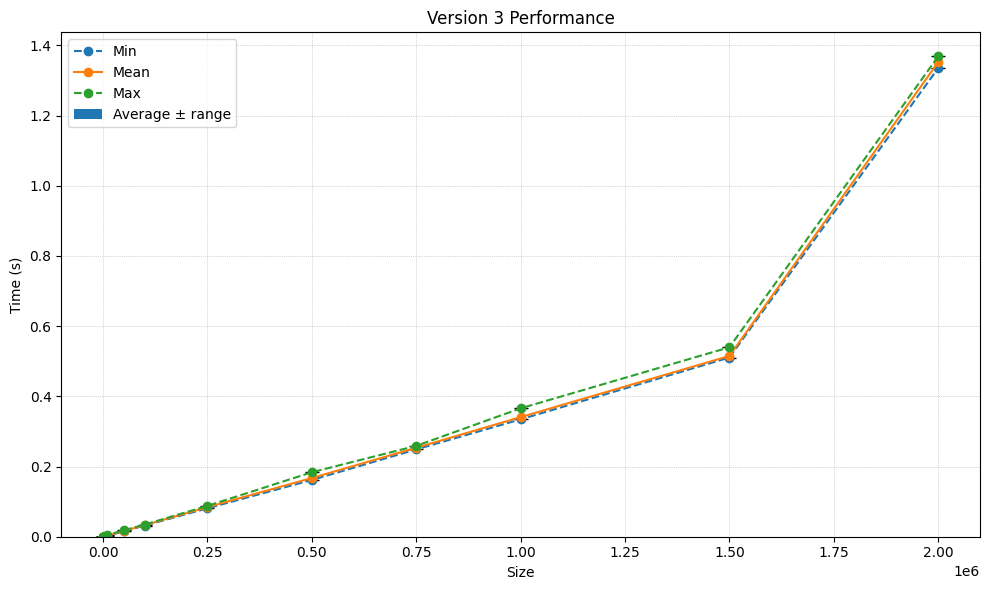

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load and normalize column names
df = pd.read_csv('results.csv', sep=',', skipinitialspace=True)
# (or use df.columns = df.columns.str.strip() if you prefer)

# 2. Ensure numeric types
df['size'] = pd.to_numeric(df['size'], errors='raise')
df['time'] = pd.to_numeric(df['time'], errors='raise')

# 3. Group & aggregate
summary = (
    df
    .groupby(['version', 'size'])['time']
    .agg(min_time='min', avg_time='mean', max_time='max')
    .reset_index()
)

# 4. Plot per version
for version, grp in summary.groupby('version'):
    sizes = grp['size']
    mins   = grp['min_time']
    avgs   = grp['avg_time']
    maxs   = grp['max_time']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bar = mean, with error bars = [avg-min, max-avg]
    err_low  = avgs - mins
    err_high = maxs - avgs
    ax.bar(sizes, avgs,
           yerr=[err_low, err_high],
           capsize=5,
           label='Average ± range')
    
    # Overlay lines
    ax.plot(sizes, mins,  marker='o', linestyle='--', label='Min')
    ax.plot(sizes, avgs,  marker='o',               label='Mean')
    ax.plot(sizes, maxs,  marker='o', linestyle='--', label='Max')
    
    ax.set_xlabel('Size')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Version {version} Performance')
    ax.legend()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()


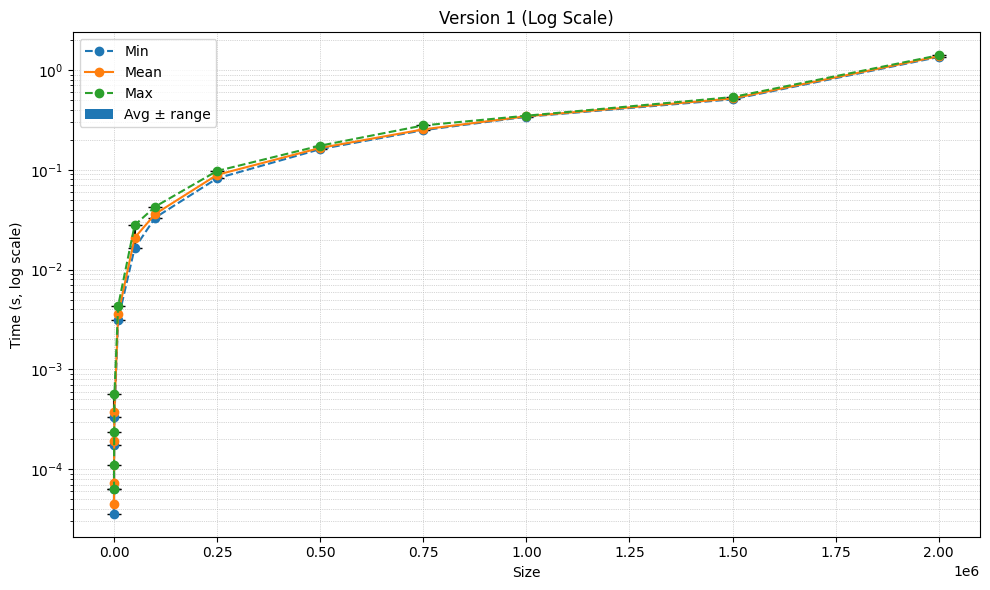

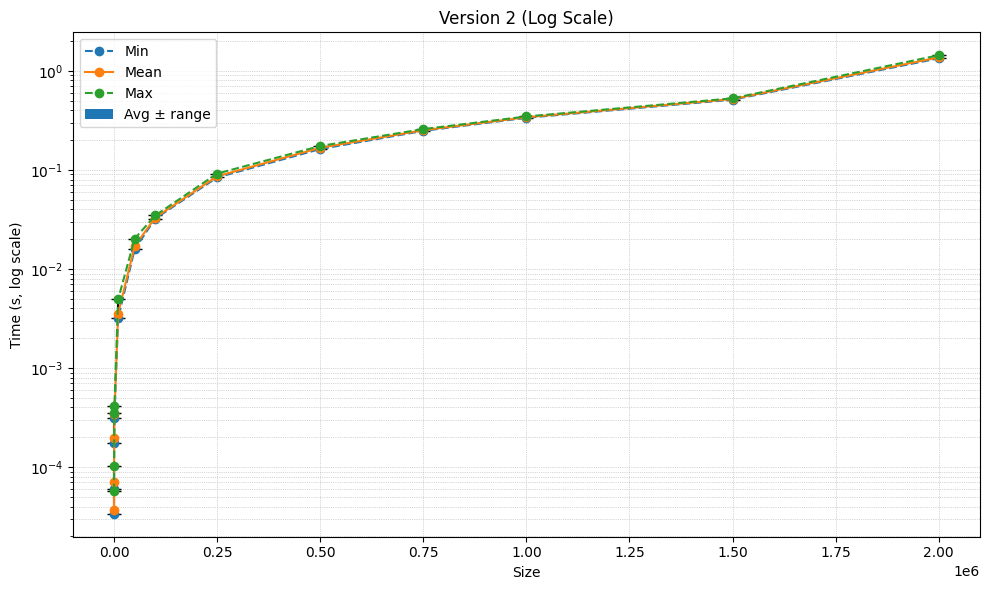

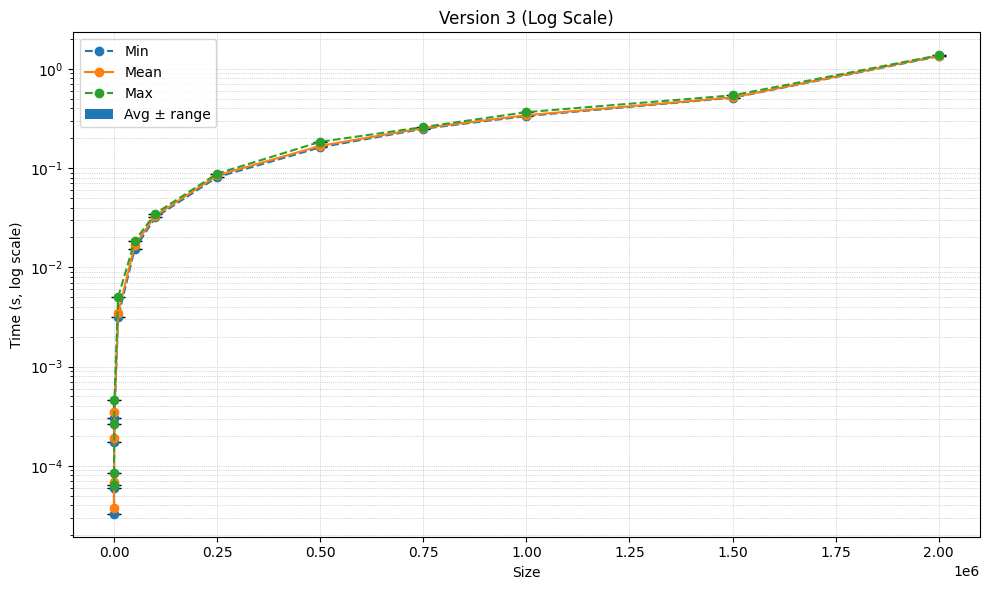

In [15]:
for version, grp in summary.groupby('version'):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(grp['size'], grp['avg_time'],
           yerr=[grp['avg_time'] - grp['min_time'], grp['max_time'] - grp['avg_time']],
           capsize=5, label='Avg ± range')
    ax.plot(grp['size'], grp['min_time'], marker='o', linestyle='--', label='Min')
    ax.plot(grp['size'], grp['avg_time'], marker='o',             label='Mean')
    ax.plot(grp['size'], grp['max_time'], marker='o', linestyle='--', label='Max')

    ax.set_yscale('log')              # <-- switch y to log scale
    ax.set_xlabel('Size')
    ax.set_ylabel('Time (s, log scale)')
    ax.set_title(f'Version {version} (Log Scale)')
    ax.legend()
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()


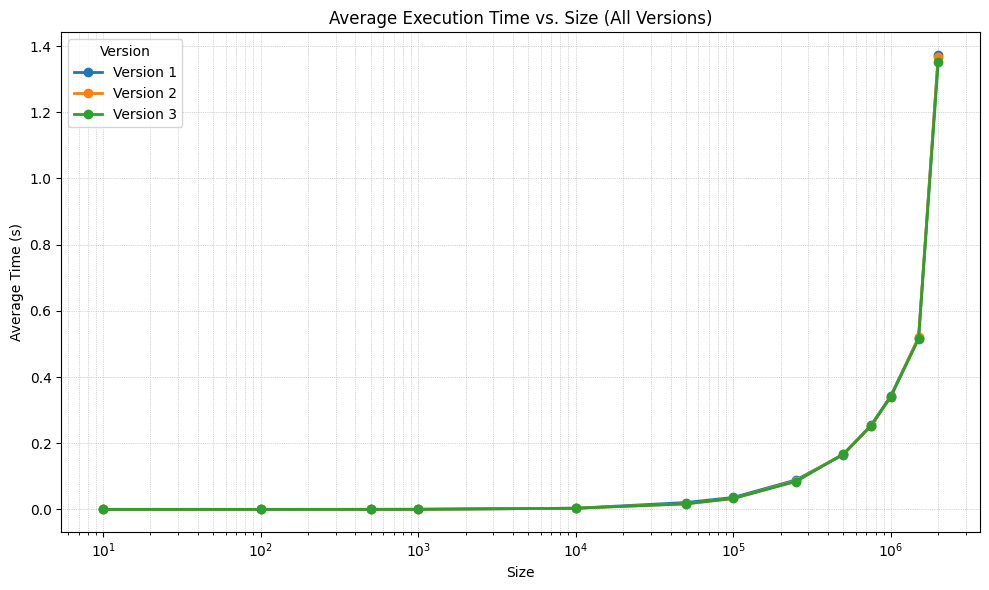

In [4]:
# — assume you’ve already built this summary:
# summary = df.groupby(['version','size'])['time'] \
#              .agg(min_time='min', avg_time='mean', max_time='max') \
#              .reset_index()

# 1. Pivot so each version’s avg_time becomes its own column
pivot = summary.pivot(index='size', columns='version', values='avg_time')

# 2. Plot them overlapped
fig, ax = plt.subplots(figsize=(10, 6))
for version in pivot.columns:
    ax.plot(pivot.index,
            pivot[version],
            marker='o',
            linewidth=2,
            label=f'Version {version}')

# 3. Styling
ax.set_xscale('log')                  # keep the log-scale if you like
ax.set_xlabel('Size')
ax.set_ylabel('Average Time (s)')
ax.set_title('Average Execution Time vs. Size (All Versions)')
ax.legend(title='Version')
ax.grid(which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


In [5]:
# pivot = summary.pivot(index='size', columns='version', values='avg_time')

# # 2. Plot them overlapped
# fig, ax = plt.subplots(figsize=(10, 6))
# for version in pivot.columns:
#     ax.plot(pivot.index,
#             pivot[version],
#             marker='o',
#             linewidth=2,
#             label=f'Version {version}')

# # 3. Styling
# ax.set_xscale('log')                  # keep the log-scale if you like
# ax.set_yscale('symlog', linthresh=1e-4)

# ax.set_xlabel('Size')
# ax.set_ylabel('Average Time')
# ax.set_title('Average Execution Time vs. Size (All Versions - power scaled)')
# ax.legend(title='Version')
# ax.grid(which='both', linestyle=':', linewidth=0.5)
# plt.tight_layout()
# plt.show()


In [6]:
# import ipywidgets as widgets
# from IPython.display import display

# sizes = pivot.index.values

# def plot_range(max_size=10000):
#     fig, ax = plt.subplots(figsize=(8, 4))
#     mask = sizes <= max_size
#     for v in diff.columns.drop(1):
#         ax.plot(sizes[mask], diff[v][mask], '-o', label=f'v{v}–v1')
#     ax.set_xscale('log')
#     ax.set_xlim(min(sizes), max_size)
#     ax.set_xlabel('Size')
#     ax.set_ylabel('Δ Time (μs)')
#     ax.legend()
#     ax.grid(True, which='both', linestyle=':')
#     plt.show()

# # Use IntSlider and apply a logarithmic transformation
# slider = widgets.IntSlider(
#     value=10000,
#     min=int(np.log10(sizes.min())),
#     max=int(np.log10(sizes.max())),
#     step=1,
#     description='Log Max Size:'
# )

# def update_plot(log_max_size):
#     max_size = 10 ** log_max_size
#     plot_range(max_size=max_size)

# widgets.interact(update_plot, log_max_size=slider)


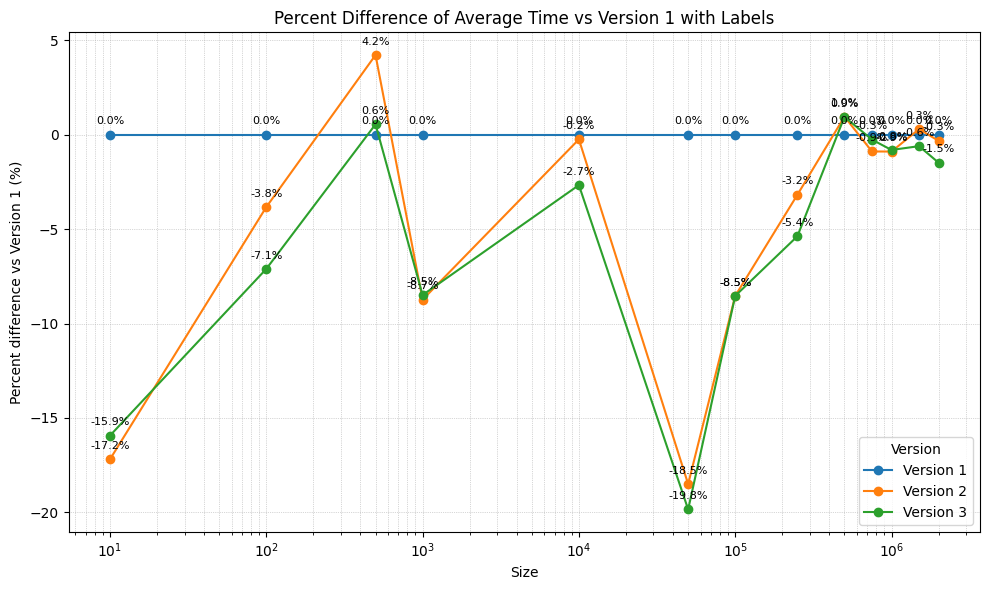

In [9]:
# Assume `summary` is already defined
pivot = summary.pivot(index='size', columns='version', values='avg_time')

# Compute percent differences vs. Version 1
pct = (pivot.subtract(pivot[1], axis=0)
          .div(pivot[1],   axis=0)
          * 100)

# Plot each version and annotate its points
fig, ax = plt.subplots(figsize=(10,6))
for v in pct.columns:
    xs = pct.index.values
    ys = pct[v].values

    # Plot the line + markers
    ax.plot(xs, ys, '-o', label=f'Version {v}')  # :contentReference[oaicite:5]{index=5}

    # Annotate each point with its percent value
    for x, y in zip(xs, ys):
        label = f"{y:.1f}%"
        ax.annotate(label,
                    xy=(x, y),
                    xytext=(0, 6),           # offset 6 points above
                    textcoords="offset points",
                    ha='center',
                    va='bottom',
                    fontsize=8)             # :contentReference[oaicite:6]{index=6}

# Final styling
ax.set_xscale('log')                                 # :contentReference[oaicite:7]{index=7}
ax.set_xlabel('Size')                               # :contentReference[oaicite:8]{index=8}
ax.set_ylabel('Percent difference vs Version 1 (%)')# :contentReference[oaicite:9]{index=9}
ax.set_title('Percent Difference of Average Time vs Version 1 with Labels')  # :contentReference[oaicite:10]{index=10}
ax.legend(title='Version')                          # :contentReference[oaicite:11]{index=11}
ax.grid(which='both', linestyle=':', linewidth=0.5) # :contentReference[oaicite:12]{index=12}
plt.tight_layout()
plt.show()